## Klimadynamics tasks 3+4
Egor Gordeev

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
from scipy.linalg import det, inv, eig
from numpy.random import normal as norm
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from scipy.stats import pearsonr

### Part 1

Read HadSLP2 (Allan & Ansell, 2006) gridded global sea level pressure (SLP)
anomalies from 1850 to 2004. Again extract the December months (alternatively
you may average over the December to February (DJF) season). Plot the longterm
mean SLP field for December (or DJF).


In [2]:
fname="/home/igor/UNI/KLIMDYN/Hometask/ex2/HadSLP2_slp-mnmean-real.nc"

In [3]:
with xr.open_dataset(fname) as ds:
    print(ds.keys())

KeysView(<xarray.Dataset>
Dimensions:    (lat: 37, lon: 72, nbnds: 2, time: 2033)
Coordinates:
  * lat        (lat) float32 90.0 85.0 80.0 75.0 ... -75.0 -80.0 -85.0 -90.0
  * lon        (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
  * time       (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2019-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    slp        (time, lat, lon) float32 ...
Attributes:
    title:        HadSLP2 Real-Time
    history:      Created 02/2006 by CAS
    comments:     adSLP2 was created using marine observations taken from ICO...
    Conventions:  CF-1.0
    platform:     Model
    source:       Hadley Center
    institution:  Hadley Center
    References:   https://hadobs.metoffice.com/gmslp/hadslp2/\nhttps://psl.no...)


In [4]:
ds_dec=ds.sel( time=ds['time.month']==1)

In [409]:
ds_dec.lat.values

array([ 90.,  85.,  80.,  75.,  70.,  65.,  60.,  55.,  50.,  45.,  40.,
        35.,  30.,  25.,  20.,  15.,  10.,   5.,   0.,  -5., -10., -15.,
       -20., -25., -30., -35., -40., -45., -50., -55., -60., -65., -70.,
       -75., -80., -85., -90.], dtype=float32)

Text(0.5, 1.0, 'SLP mean December (1850-2019)')

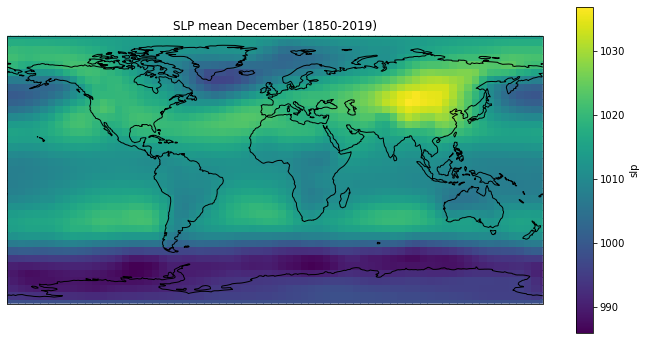

In [5]:
fig=plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ds_dec.slp.mean(axis=0).plot()
ax.coastlines()
plt.title('SLP mean December (1850-2019)')


In [6]:
# 170 time steps (years), 37 Y steps (latitude), 72 X steps (longitude, zones)
ds_dec.slp.shape

(170, 37, 72)

In [7]:
# find matrix H by averaging over longitudes
H=ds_dec.slp.mean(axis=2)

In [8]:
H.shape[1]

37

I.
Calculate zonal mean SLP anomalies a , which is a 2-dimensional array with nlat
number of latitudes and nt number of times (December or DJF). You may denote
the anomaly matrix (Matrix der zentrierten Differenzen) according to the lecture as
D.
- Plot D in a so-called Hovmoeller diagram, with latitudes on x-axis and time
on y-axis. What do you see?
- Plot the respective covariate matrix estimated as 1/mDD T . What do you
see?

In [13]:
def get_deviation_vect(lat_vect,ntime_steps):
    lat_mean=sum(lat_vect)/ntime_steps
    # deviation_vect - deviations from mean
    deviation_vect=lat_vect-lat_mean
    deviation_vect
    
    return deviation_vect

def get_D(H):
    ntime_steps=H.shape[0]
    latitudes=H.lat.values
    dev_list=[]
    for lat in latitudes:
        # latitudinal vector n with 170 time entries
        lat_vect=H.sel(lat=lat)
        dev_list.append(get_deviation_vect(lat_vect,ntime_steps))

    D=np.array(dev_list)
    
    return D,ntime_steps

def get_covmat(H):
    
    D,m=get_D(H)
    
    cov_mat = 1/m * np.matmul(D,D.T)
    
    return cov_mat

In [29]:
covmat=get_covmat(H)
D,m=get_D(H)

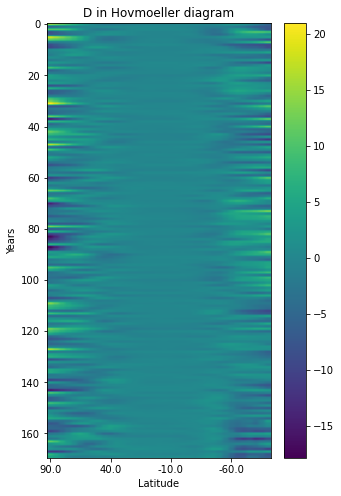

In [406]:
fig=plt.figure(figsize=(5,8))
plt.title('D in Hovmoeller diagram')
plt.imshow(D.T,aspect='auto')
plt.ylabel('Years')
plt.xticks(range(37)[::10],H.lat.values[::10])
plt.xlabel('Latitude')
plt.colorbar()

Most variations are in  polar areas.

Text(0.5, 1.0, 'zonal mean SLP anomalies (December 1850-2019)')

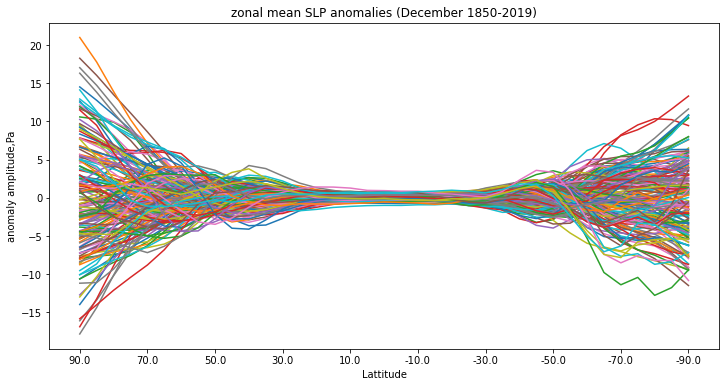

In [47]:
fig=plt.figure(figsize=(12,6))
plt.plot(D[:])
plt.xticks(range(37)[::4],H.lat.values[::4])
plt.xlabel('Lattitude')
plt.ylabel('anomaly amplitude,Pa')
plt.title('zonal mean SLP anomalies (December 1850-2019)')

Text(0.5, 1.0, 'covariance matrix')

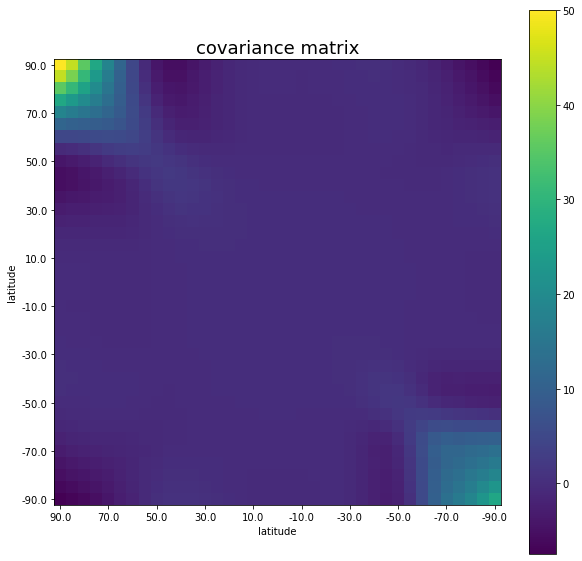

In [47]:
fig=plt.figure(figsize=(10,10))
plt.imshow(covmat,vmax=50)
plt.xticks(range(37)[::4],H.lat.values[::4])
plt.xlabel('latitude')
plt.ylabel('latitude')
plt.yticks(range(37)[::4],H.lat.values[::4])
plt.colorbar()
plt.title('covariance matrix',fontsize=18)

On diagonal we see the variances of SLP at different latitudes.These variances are high in near polar areas, meaning that SLP values change more significantly there from year to year. Off-diagonal values show the covariances of SLP at different latitudes. There is strong positive correlation in near polar covariance, meaning that Kthe SLP change occur in the same direction at these latitudes. Zero covariance means no correlation between changes in SLP at latitudes.

Text(0.5, 1.0, 'Diagonal values of covariance matrix')

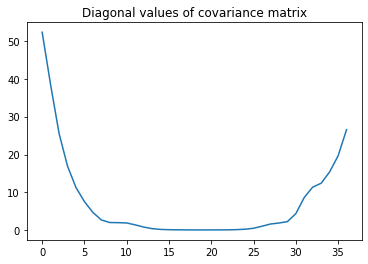

In [48]:
plt.plot(covmat.diagonal())
plt.title('Diagonal values of covariance matrix')

### PART II
Calculate and plot the results of a principal component analysis.
- Plot the eigenvalues as well as the explained variances of the covariance
matrix as estimated in I. (explained variance: the fraction of variance
explained by the first k eigenvalues as a function of k).
- Plot the first two eigenvectors. What do they tell us?
- Plot the corresponding principal components of the first two eigenvectors.

In [300]:
# eig returns The normalized left eigenvector corresponding to the eigenvalue
#``w[i]`` is the column vl[:,i]
l, E = eig(covmat)  # eigen_val, eigen_vec
idx = l.argsort()[::-1] 
# E - eigenvector columns, E.T - eigenvector rows
E = np.array([E[:, i] for i in idx]).T  # reorder as eig doesn't necessarily return ordered values
l_sorted = l[idx]

Text(0.5, 1.0, '3 first eigenectors')

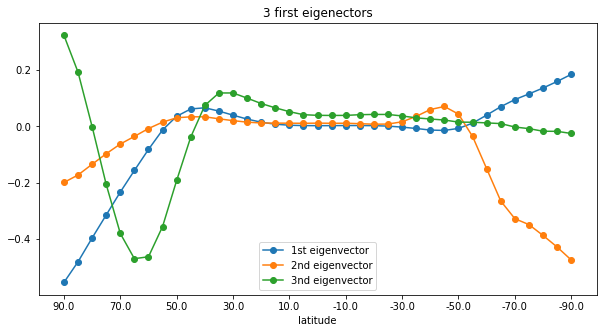

In [299]:
# plot 3 first eigenvectors
fig=plt.figure(figsize=(10,5))
plt.plot(E[:,0],'-o',label='1st eigenvector')
plt.plot(E[:,1],'-o',label='2nd eigenvector')
plt.plot(E[:,2],'-o',label='3nd eigenvector')
plt.xticks(range(37)[::4],H.lat.values[::4])
plt.xlabel('latitude')
plt.legend()
plt.title('3 first eigenectors')

Biggest eigenvectors have biggest components, corresponding to north polar area. In the south polar area contribution is the smallest. 
Eigenvector can be thought as basis vector. In our case the are 37 such vectors, each one in 37-dimensional space. Eiegenvectors corresponding to biggest eigenvalues (coordinates in our 37-dimension space). Looking at the biggest components of two first eigenvectors we can tell the most important subspace of our problem.

Text(0, 0.5, 'eigenvalue value')

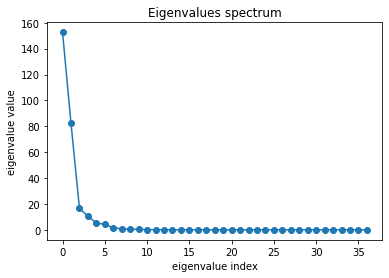

In [301]:
plt.plot(l_sorted.real,'-o')
plt.title('Eigenvalues spectrum')
plt.xlabel('eigenvalue index')
plt.ylabel('eigenvalue value')

First two eigenvalues are significantly bigger then the rest.

In [302]:
# calculate principle components (A).
# X - 37x170 matrix 
A = E.T@ D  # principal components

Eiegnvalues should be applied to the anomalies matrix D, not to the matrix of absolute variables X. 

### Part 3
Calculate and plot the filtered variability in terms of fildered D f il = Û Â = Û Û D.
T
- Plot the filter Û Û .
- Plot the Hovmoeller diagram of the filtered variability and the differences.

Text(0.5, 1.0, 'Two first principle comoponents')

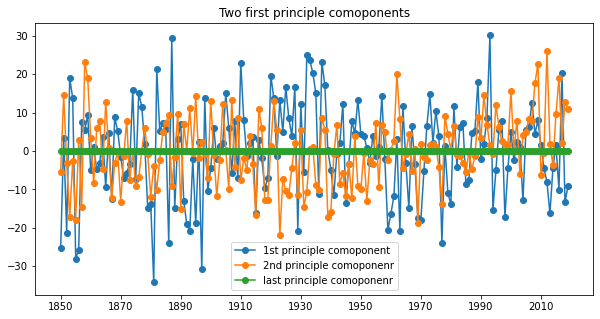

In [303]:
# plot two first eigenvectors
fig=plt.figure(figsize=(10,5))
plt.plot(A[0],'-o',label='1st principle comoponent')
plt.plot(A[1],'-o',label='2nd principle comoponenr')
plt.plot(A[-1],'-o',label='last principle comoponenr')
plt.xticks(range(170)[::20],H['time.year'].values[::20])
plt.legend()
plt.title('Two first principle comoponents')

So we see the most variance along the first two 'axes'(most important principle components) and the least variance along the last 37-th axis. 

In [304]:
D.shape

(37, 170)

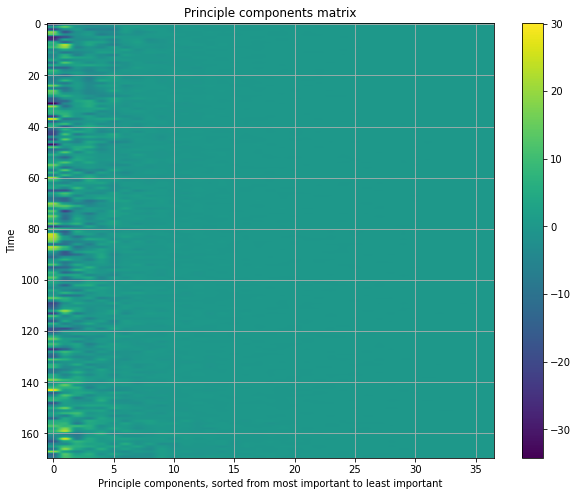

In [305]:
fig=plt.figure(figsize=(10,8))
plt.imshow(A.T, aspect='auto')
plt.title('Principle components matrix')
plt.xlabel('Principle components, sorted from most important to least important')
plt.ylabel('Time')
plt.grid()
plt.colorbar()

In [330]:
def filter(D,nprinciple):
    # assume proper array shape
    assert E[:,:nprinciple].shape[0]==D.shape[0]
    filter_matrix=np.matmul(E[:,:nprinciple],E[:,:nprinciple].T)
    
    return np.matmul(filter_matrix,D)


Text(0.5, 1.0, 'D filtered - D unfiltered: filtered out data ')

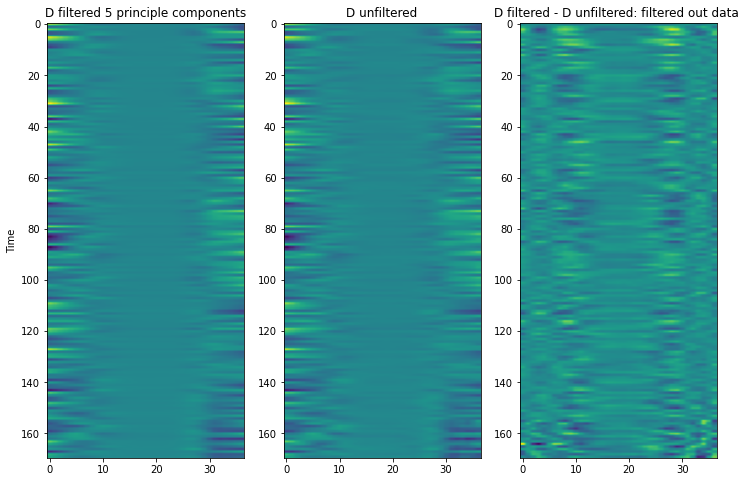

In [403]:
nprinciple=5
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(12,8))
im=ax1.imshow(filter(D,nprinciple).T,aspect='auto')
ax1.set_title('D filtered {} principle components'.format(nprinciple))
ax1.set_ylabel('Time')
ax2.imshow(D.T,aspect='auto')
ax2.set_title('D unfiltered')
ax3.imshow((filter(D,nprinciple)-D).T,aspect='auto')
ax3.set_title('D filtered - D unfiltered: filtered out data ')

Filter worked good and managed to filter out the 'high frequency', low amplitude components, which can be seen on the right subplot.

In [370]:
ff=np.matmul(E[:,:4],E[:,:4].T)

### Part 4
Repeat analysis with weights such that the variance (covariance) is weighted with
the area that is represented by the grid points, which is proportional to the cosine
of the geographic latitude. This is performed by multiplication of D with a weight
√︁
matrix diag( cos(φ j )

In [434]:
# get list on latitude cos
latlist=ds_dec.lat.values
coslist=np.cos(np.deg2rad(latlist))
coslist[0]=coslist[-1]=0

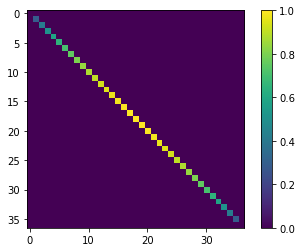

In [435]:
# weights matrix
W=np.diag(np.sqrt(coslist))
plt.imshow(W)
plt.colorbar()

In [439]:
def weighted_filter(D,W,nprinciple):
    # assume proper array shape
    assert E[:,:nprinciple].shape[0]==D.shape[0]
    filter_matrix=np.matmul(E[:,:nprinciple],E[:,:nprinciple].T)
    Dweighted=np.matmul(W,D)
    
    return np.matmul(filter_matrix,Dweighted)


In [447]:
range(37)[::10]

range(0, 37, 10)

In [449]:
help(ax3.set_xticks)

Help on method set_xticks in module matplotlib.axes._base:

set_xticks(ticks, *, minor=False) method of matplotlib.axes._subplots.AxesSubplot instance
    Set the x ticks with list of *ticks*
    
    Parameters
    ----------
    ticks : list
        List of x-axis tick locations.
    
    minor : bool, optional
        If ``False`` sets major ticks, if ``True`` sets minor ticks.
        Default is ``False``.



([<matplotlib.axis.XTick at 0x7fa64a932d60>,
 [Text(0, 0, '90.0'),
  Text(0, 0, '40.0'),
  Text(0, 0, '-10.0'),
  Text(0, 0, '-60.0')])

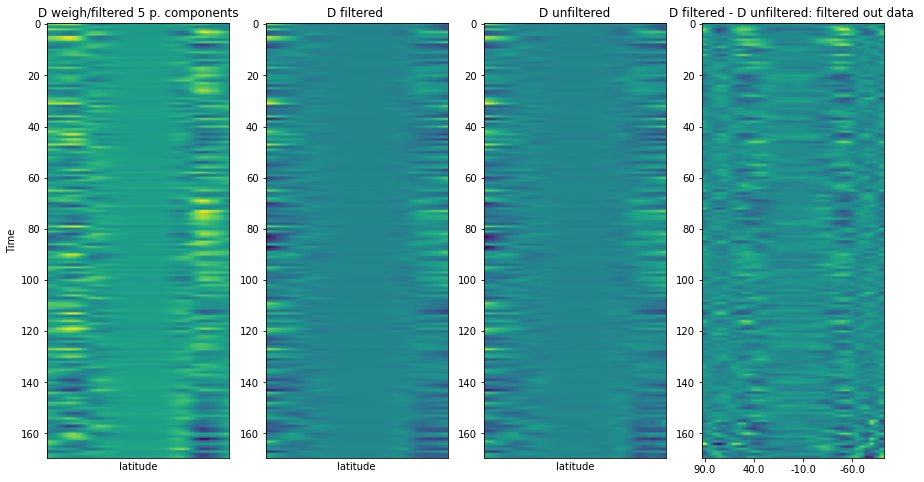

In [467]:
nprinciple=5
fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4,figsize=(15,8))
ax1.imshow(weighted_filter(D,W,nprinciple).T,aspect='auto')
ax1.set_title('D weigh/filtered {} p. components'.format(nprinciple))
ax1.set_ylabel('Time')
ax3.imshow(D.T,aspect='auto')
ax3.set_title('D unfiltered')
ax2.imshow((filter(D,nprinciple)).T,aspect='auto')
ax2.set_title('D filtered ')
ax4.imshow((filter(D,nprinciple)-D).T,aspect='auto')
ax4.set_title('D filtered - D unfiltered: filtered out data ')
for ax in [ax1,ax2,ax3]:
    ax.set_xticks([])
    ax.set_xlabel('latitude')
plt.xticks(range(37)[::10],latlist[::10])